In [2]:
import json
from pathlib import Path

import numpy as np
from scipy.stats import bootstrap, gmean
from matplotlib import pyplot as plt
from tqdm import tqdm

fig1-full-mnist-filtered


100%|██████████| 32/32 [00:00<00:00, 655.34it/s]
/opt/cray/pe/python/3.10.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_49679/965237.py:42: RuntimeWarning: Mean of empty slice
  mean_stat = lambda x, axis: np.nanmean(x, axis=axis)
100%|██████████| 32/32 [00:00<00:00, 251.11it/s]


fig1-ba-filtered


100%|██████████| 64/64 [00:00<00:00, 68.99it/s]


fig1-regular-cifar10-filtered


100%|██████████| 16/16 [00:00<00:00, 252.72it/s]


fig1-full-mnist-adam-filtered


100%|██████████| 16/16 [00:00<00:00, 212.94it/s]


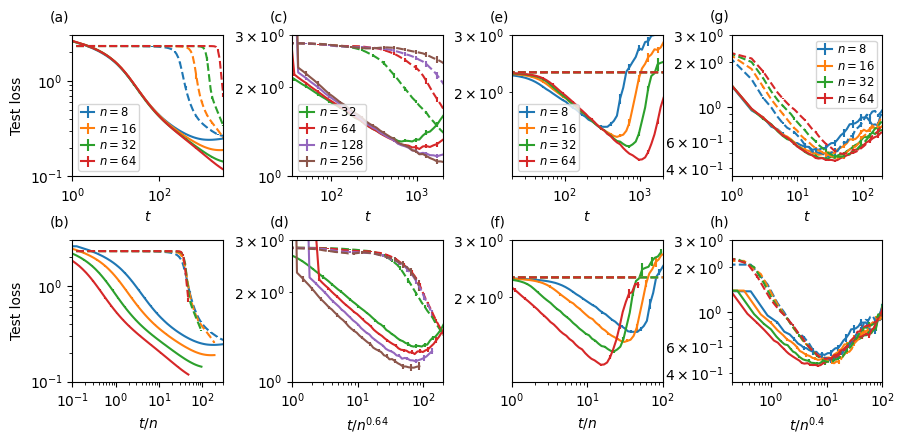

In [23]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(8.1, 4.5),
                         # sharey="row",
                         gridspec_kw={"wspace": 0.46, "hspace": 0.45, "left": 0.0, "right": 1.0})

scenarios = ["fig1-full-mnist-filtered", "fig1-ba-filtered", "fig1-regular-cifar10-filtered", "fig1-full-mnist-adam-filtered"]
corrections = ["sqrt", "graph", "sqrt", "sqrt"]
sizes = [
    [8, 16, 32, 64],
    [32, 64, 128, 256],
    [8, 16, 32, 64],
    [8, 16, 32, 64],
]

ylims = [
    (0.1, 3.0),
    (1.0, 3.0),
    (1.1, 3.0),
    (0.35, 3.0),
]
ax1_xlims = [
    (1, 3000),
    (35, 2000),
    (20, 2000),
    (1, 200),
]
ax2_xlims = [
    (0.1, 300),
    (1, 200),
    (1, 100),
    (0.2, 100),
]


n_exps = [1, 0.64, 1, 0.4]

cols = dict(
    zip([2**n for n in range(3, 10)],
        list(plt.rcParams['axes.prop_cycle'].by_key()['color'])))


# mean_stat = lambda x, axis: gmean(x, nan_policy='omit', axis=axis)
mean_stat = lambda x, axis: np.nanmean(x, axis=axis)


for scenario, correction, this_sizes, ylim, n_exp, \
        ax1_xlim, ax2_xlim, (ax1, ax2) in zip(scenarios, corrections, sizes, ylims, n_exps, ax1_xlims, ax2_xlims, axes.T):
    print(scenario)
    errorevery = 3

    for size in this_sizes:
        files = list(Path(f"../logs/{scenario}/").glob(f"nodes-{size}-seed-*-correction-{correction}*.jsonl"))
        all_mean_losses = []
        all_rounds = []
        for fn in tqdm(files):
            rounds = []
            mean_losses = []
            with open(fn) as f:
                for line in f:
                    try:
                        res = json.loads(line)
                    except json.JSONDecodeError:
                        continue
                    rounds.append(res["round"])
                    mean_losses.append(np.mean(list(res["test_losses"].values())))
            all_mean_losses.append(mean_losses+[np.nan]*(91-len(mean_losses)))
            all_rounds.append(rounds)
        rs = max(all_rounds, key=len)
        # print(rs)
        # yerr = bootstrap(all_mean_losses, statistic=lambda *x, axis: np.mean(x, axis=axis), n_resamples=100, vectorized=True, axis=0) - np.nanmean(all_mean_losses, axis=0)
        # yerr = np.nanpercentile(all_mean_losses, [2.5, 97.5], axis=0) - np.nanmean(all_mean_losses, axis=0)
        # yerr = np.abs(yerr)[:, :len(rs)]
        yerr = 1.96*(np.nanstd(all_mean_losses, axis=0)/np.sum(~np.isinf(all_mean_losses), axis=0)**0.5)[:len(rs)]
        yerr[yerr > 1] = 0
        ax1.errorbar(rs, mean_stat(all_mean_losses, axis=0)[:len(rs)],
                     yerr=yerr,
                     errorevery=errorevery,
                     label=f"$n={size}$", color=cols[size])
        ax2.errorbar(np.array(rs)/size**n_exp, mean_stat(all_mean_losses, axis=0)[:len(rs)],
                     yerr=yerr,
                     errorevery=errorevery,
                     # label=f"$n={size}$",
                     color=cols[size])


    for size in this_sizes:
        files = list(Path(f"../logs/{scenario}/").glob(f"nodes-{size}-seed-*-correction-none*.jsonl"))
        all_mean_losses = []
        all_rounds = []
        for fn in tqdm(files):
            rounds = []
            mean_losses = []
            with open(fn) as f:
                for line in f:
                    try:
                        res = json.loads(line)
                    except json.JSONDecodeError:
                        continue
                    rounds.append(res["round"])
                    mean_losses.append(np.mean(list(res["test_losses"].values())))
            all_mean_losses.append(mean_losses+[np.nan]*(91-len(mean_losses)))
            all_rounds.append(rounds)
        if not all_rounds:
            continue
        rs = max(all_rounds, key=len)
        # print(size, len(rs), len(all_rounds))
        # yerr = np.nanpercentile(all_mean_losses, [2.5, 97.5], axis=0) - np.nanmean(all_mean_losses, axis=0)
        # yerr = np.abs(yerr)[:, :len(rs)]
        yerr = 1.96*(np.nanstd(all_mean_losses, axis=0)/np.sum(~np.isinf(all_mean_losses), axis=0)**0.5)[:len(rs)]
        yerr[yerr > 1] = 0
        ax1.errorbar(rs, mean_stat(all_mean_losses, axis=0)[:len(rs)],
                     yerr=yerr,
                     errorevery=errorevery,
                     ls="--", color=cols[size])
        ax2.errorbar(np.array(rs)/size**n_exp, mean_stat(all_mean_losses, axis=0)[:len(rs)],
                     yerr=yerr,
                     errorevery=errorevery,
                     label=f"$n={size}$",
                     ls="--", color=cols[size])
    
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_xlim(*ax2_xlim)
    ax2.set_ylim(*ylim)
    ax1.legend(fontsize="small", borderpad=0.2, labelspacing=0.3, handlelength=1.2, handletextpad=0.4)
    
    ax1.set_ylim(*ylim)
    ax1.set_xlim(*ax1_xlim)
    ax1.set_yscale("log")
    ax1.set_xscale("log")
    ax1.set_xlabel("$t$")
    if n_exp == 1.0:
        ax2.set_xlabel(f"$t/n$")
    else:    
        ax2.set_xlabel(f"$t/n^{{{n_exp}}}$")

axes[0, 0].set_ylabel("Test loss")
axes[1, 0].set_ylabel("Test loss")


import string
for ax, let in zip(axes.T.ravel(), string.ascii_lowercase):
    ax.text(-0.15, 1.1, f"({let})", transform=ax.transAxes)

In [24]:
fig.savefig("fig1.pdf", bbox_inches="tight")

100%|██████████| 32/32 [00:00<00:00, 101.02it/s]
/opt/cray/pe/python/3.10.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_137725/2113777576.py:13: RuntimeWarning: Mean of empty slice
  mean_stat = lambda x, axis: np.nanmean(x, axis=axis)
100%|██████████| 32/32 [00:00<00:00, 98.34it/s]


Text(0.5, 0, 'Communication rounds $t$')

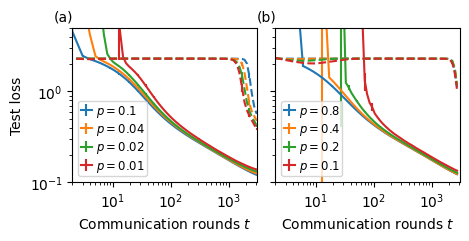

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(5.0, 2.0),
                         sharey="row",
                         gridspec_kw={"wspace": 0.10, "hspace": 0.45})

correction = "sqrt"
size = 64
ylim = (0.1, 5.0)
ax1_xlim = (2, 3100)
ax2_xlim = (-100, 3100)
probs = [0.1, 0.04, 0.02, 0.01]
cols = dict(
    zip(probs, list(plt.rcParams['axes.prop_cycle'].by_key()['color'])))
mean_stat = lambda x, axis: np.nanmean(x, axis=axis)


errorevery = 3


scenario = "fig1-full-mnist-bond-filtered"
for p in probs:
    files = list(Path(f"../logs/{scenario}/").glob(f"nodes-{size}-seed-*-correction-{correction}-prob-{p}.jsonl"))
    all_mean_losses = []
    all_rounds = []
    for fn in tqdm(files):
        rounds = []
        mean_losses = []
        with open(fn) as f:
            for line in f:
                try:
                    res = json.loads(line)
                except json.JSONDecodeError:
                    continue
                rounds.append(res["round"])
                mean_losses.append(np.mean(list(res["test_losses"].values())))
        all_mean_losses.append(mean_losses+[np.nan]*(91-len(mean_losses)))
        all_rounds.append(rounds)
    rs = max(all_rounds, key=len)
    # print(rs)
    # yerr = bootstrap(all_mean_losses, statistic=lambda *x, axis: np.mean(x, axis=axis), n_resamples=100, vectorized=True, axis=0) - np.nanmean(all_mean_losses, axis=0)
    # yerr = np.nanpercentile(all_mean_losses, [2.5, 97.5], axis=0) - np.nanmean(all_mean_losses, axis=0)
    # yerr = np.abs(yerr)[:, :len(rs)]
    yerr = 1.96*(np.nanstd(all_mean_losses, axis=0)/np.sum(~np.isinf(all_mean_losses), axis=0)**0.5)[:len(rs)]
    # yerr[:26] = 0
    ax1.errorbar(rs, mean_stat(all_mean_losses, axis=0)[:len(rs)],
                 yerr=yerr,
                 errorevery=errorevery,
                 label=f"$p={p}$", color=cols[p])


for p in probs:
    files = list(Path(f"../logs/{scenario}/").glob(f"nodes-{size}-seed-*-correction-none-prob-{p}.jsonl"))
    all_mean_losses = []
    all_rounds = []
    for fn in tqdm(files):
        rounds = []
        mean_losses = []
        with open(fn) as f:
            for line in f:
                try:
                    res = json.loads(line)
                except json.JSONDecodeError:
                    continue
                rounds.append(res["round"])
                mean_losses.append(np.mean(list(res["test_losses"].values())))
        all_mean_losses.append(mean_losses+[np.nan]*(91-len(mean_losses)))
        all_rounds.append(rounds)
    if not all_rounds:
        continue
    rs = max(all_rounds, key=len)
    # print(size, len(rs), len(all_rounds))
    # yerr = np.nanpercentile(all_mean_losses, [2.5, 97.5], axis=0) - np.nanmean(all_mean_losses, axis=0)
    # yerr = np.abs(yerr)[:, :len(rs)]
    yerr = 1.96*(np.nanstd(all_mean_losses, axis=0)/np.sum(~np.isinf(all_mean_losses), axis=0)**0.5)[:len(rs)]
    # yerr[:26] = 0
    ax1.errorbar(rs, mean_stat(all_mean_losses, axis=0)[:len(rs)],
                 yerr=yerr,
                 errorevery=errorevery,
                 ls="--", color=cols[p])


probs = [0.8, 0.4, 0.2, 0.1]
cols = dict(
    zip(probs, list(plt.rcParams['axes.prop_cycle'].by_key()['color'])))
scenario = "fig1-full-mnist-site-filtered"
for p in probs:
    files = list(Path(f"../logs/{scenario}/").glob(f"nodes-{size}-seed-*-correction-{correction}-prob-{p}.jsonl"))
    all_mean_losses = []
    all_rounds = []
    for fn in tqdm(files):
        rounds = []
        mean_losses = []
        with open(fn) as f:
            for line in f:
                try:
                    res = json.loads(line)
                except json.JSONDecodeError:
                    continue
                rounds.append(res["round"])
                mean_losses.append(np.mean(list(res["test_losses"].values())))
        all_mean_losses.append(mean_losses+[np.nan]*(91-len(mean_losses)))
        all_rounds.append(rounds)
    rs = max(all_rounds, key=len)
    # print(rs)
    # yerr = bootstrap(all_mean_losses, statistic=lambda *x, axis: np.mean(x, axis=axis), n_resamples=100, vectorized=True, axis=0) - np.nanmean(all_mean_losses, axis=0)
    # yerr = np.nanpercentile(all_mean_losses, [2.5, 97.5], axis=0) - np.nanmean(all_mean_losses, axis=0)
    # yerr = np.abs(yerr)[:, :len(rs)]
    yerr = 1.96*(np.nanstd(all_mean_losses, axis=0)/np.sum(~np.isinf(all_mean_losses), axis=0)**0.5)[:len(rs)]
    # yerr[:26] = 0
    ax2.errorbar(rs, mean_stat(all_mean_losses, axis=0)[:len(rs)],
                 yerr=yerr,
                 errorevery=errorevery,
                 label=f"$p={p}$", color=cols[p])


for p in probs:
    files = list(Path(f"../logs/{scenario}/").glob(f"nodes-{size}-seed-*-correction-none-prob-{p}.jsonl"))
    all_mean_losses = []
    all_rounds = []
    for fn in tqdm(files):
        rounds = []
        mean_losses = []
        with open(fn) as f:
            for line in f:
                try:
                    res = json.loads(line)
                except json.JSONDecodeError:
                    continue
                rounds.append(res["round"])
                mean_losses.append(np.mean(list(res["test_losses"].values())))
        all_mean_losses.append(mean_losses+[np.nan]*(91-len(mean_losses)))
        all_rounds.append(rounds)
    if not all_rounds:
        continue
    rs = max(all_rounds, key=len)
    # print(size, len(rs), len(all_rounds))
    # yerr = np.nanpercentile(all_mean_losses, [2.5, 97.5], axis=0) - np.nanmean(all_mean_losses, axis=0)
    # yerr = np.abs(yerr)[:, :len(rs)]
    yerr = 1.96*(np.nanstd(all_mean_losses, axis=0)/np.sum(~np.isinf(all_mean_losses), axis=0)**0.5)[:len(rs)]
    # yerr[:26] = 0
    ax2.errorbar(rs, mean_stat(all_mean_losses, axis=0)[:len(rs)],
                 yerr=yerr,
                 errorevery=errorevery,
                 ls="--", color=cols[p])



ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlim(*ax1_xlim)
# ax2.set_ylim(2, 3)
# ax2.set_ylabel("Test loss")
ax1.legend(fontsize="small",
           # bbox_to_anchor=(1, 1),
           ncols=1, borderpad=0.2, labelspacing=0.2,
           handlelength=1.0, handletextpad=0.3,
           columnspacing=0.8)

ax2.legend(fontsize="small",
           # bbox_to_anchor=(1, 1),
           ncols=1, borderpad=0.2, labelspacing=0.2,
           handlelength=1.0, handletextpad=0.3,
           columnspacing=0.8)

ax1.text(-0.1, 1.05, "(a)",
         transform=ax1.transAxes)
ax2.text(-0.1, 1.05, "(b)",
         transform=ax2.transAxes)

ax1.set_ylim(*ylim)
ax1.set_xlim(*ax1_xlim)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Test loss")
ax1.set_xlabel("Communication rounds $t$")
ax2.set_xlabel("Communication rounds $t$")

In [28]:
fig.savefig("fig_prob.pdf", bbox_inches="tight")